# POLI 175 - Lecture 23

## Support Vector Machines III and Deep Learning I

# Support Vector Machines

In [1]:
## Loading the relevant packages
import pandas as pd
import numpy as np

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt

# Look at our friend here to help with GAM
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# Loading scikit learn relevant packages (note our new friends!)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score, mean_squared_error, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import VotingClassifier, BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

In [2]:
## Loading Chile data
chile = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/chilesurvey.csv')
chile_clean = chile.dropna()
chile_clean = chile_clean[chile_clean['vote'].isin(['Y', 'N'])]
chile_clean['vote'] = np.where(chile_clean['vote'] == 'Y', 1, 0)
chile_clean['logincome'] = np.log(chile_clean['income'])
chile_clean['logpop'] = np.log(chile_clean['population'])
dummies = pd.get_dummies(chile_clean['sex'], prefix = 'sex', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
dummies = pd.get_dummies(chile_clean['region'], prefix = 'region', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
dummies = pd.get_dummies(chile_clean['education'], prefix = 'education', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
chile_clean.head()

,region,population,sex,age,education,income,statusquo,vote,logincome,logpop,sex_M,region_M,region_N,region_S,region_SA,education_PS,education_S
0,N,175000,M,65.0,P,35000.0,1.00820,1,10.463103,12.072541,1,0,1,0,0,0,0
1,N,175000,M,29.0,PS,7500.0,-1.29617,0,8.922658,12.072541,1,0,1,0,0,1,0
2,N,175000,F,38.0,P,15000.0,1.23072,1,9.615805,12.072541,0,0,1,0,0,0,0
3,N,175000,F,49.0,P,35000.0,-1.03163,0,10.463103,12.072541,0,0,1,0,0,0,0
4,N,175000,F,23.0,S,35000.0,-1.10496,0,10.463103,12.072541,0,0,1,0,0,0,1


In [3]:
## Loading Chile data
y = chile_clean['vote']
X = chile_clean[['age', 'statusquo']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 12345)

## Support Vector Machines

- Now, let us change the `kernel`. We will start with a polynomial kernel to warm up.

In [4]:
## Polynomial SVM (Support Vector Classifier) ## btw: default is cubic
svc = SVC(kernel = 'poly').fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[253   7]
 [ 70 181]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       260
           1       0.96      0.72      0.82       251

    accuracy                           0.85       511
   macro avg       0.87      0.85      0.85       511
weighted avg       0.87      0.85      0.85       511



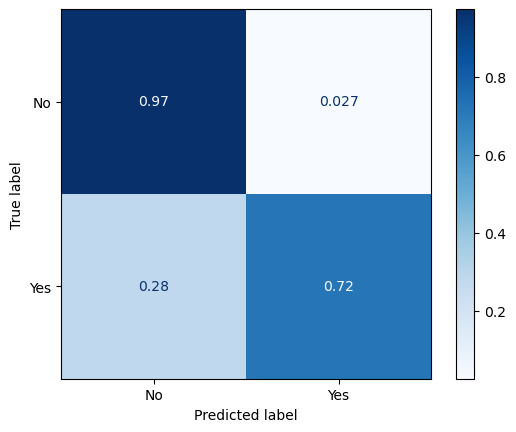

In [5]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        display_labels = ['No', 'Yes'],
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

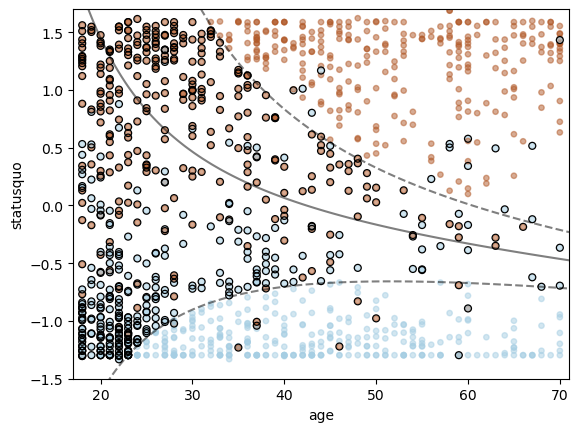

In [6]:
# Decision Function with Support Vectors
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap=plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

ax.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s = 25,
    linewidth = 0.9,
    facecolors = "none",
    edgecolors = "k",
    alpha = 1
)

plt.ylim(-1.5, 1.7)
plt.show()

## Support Vector Machines

- Now, let us improve our model by use GridSearchCV to find the best $C$ and $degree$ for our problem.

In [7]:
## Choosing the best C
Cs = np.logspace(0, 2, 25)
dge = np.arange(1, 6)

# Model
svc = SVC(kernel = 'poly')

# Parameters for gridsearch
param_grid = {
    'C': Cs,
    'degree': dge
}

# Build the GridSearch
search = GridSearchCV(svc, param_grid, n_jobs = -1)
search.fit(X_train, y_train)

# Results
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

## Using the best parameters
svc = search.best_estimator_
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameter (CV score=0.921):
{'C': 5.623413251903491, 'degree': 2}
[[249  11]
 [ 24 227]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       260
           1       0.95      0.90      0.93       251

    accuracy                           0.93       511
   macro avg       0.93      0.93      0.93       511
weighted avg       0.93      0.93      0.93       511



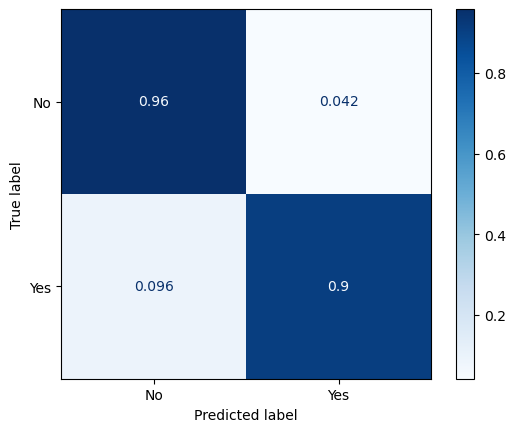

In [8]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        display_labels = ['No', 'Yes'],
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

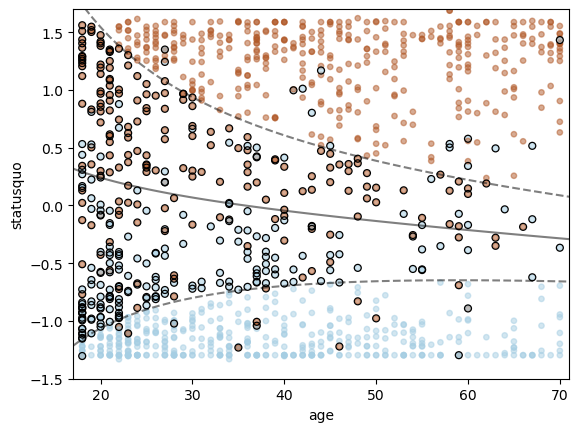

In [9]:
# Decision Function with Support Vectors
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap=plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

ax.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s = 25,
    linewidth = 0.9,
    facecolors = "none",
    edgecolors = "k",
    alpha = 1
)

plt.ylim(-1.5, 1.7)
plt.show()

## Support Vector Machines

- Now, let us use the radial kernel (the circle thingy from the previous class).

In [10]:
## Choosing the best C and gammas
Cs = np.logspace(0, 2, 25)
gammas = np.logspace(-1, 1, 25)

# Model (Radial Kernel)
svc = SVC(kernel = 'rbf')

# Parameters for gridsearch
param_grid = {
    'C': Cs,
    'gamma': gammas
}

# Build the GridSearch
search = GridSearchCV(svc, param_grid, n_jobs = -1)
search.fit(X_train, y_train)

# Results
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

## Using the best parameters
svc = search.best_estimator_
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameter (CV score=0.922):
{'C': 56.23413251903491, 'gamma': 0.1}
[[245  15]
 [ 28 223]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       260
           1       0.94      0.89      0.91       251

    accuracy                           0.92       511
   macro avg       0.92      0.92      0.92       511
weighted avg       0.92      0.92      0.92       511



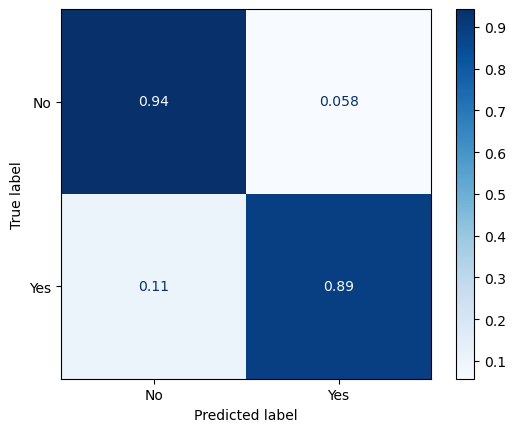

In [11]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        display_labels = ['No', 'Yes'],
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

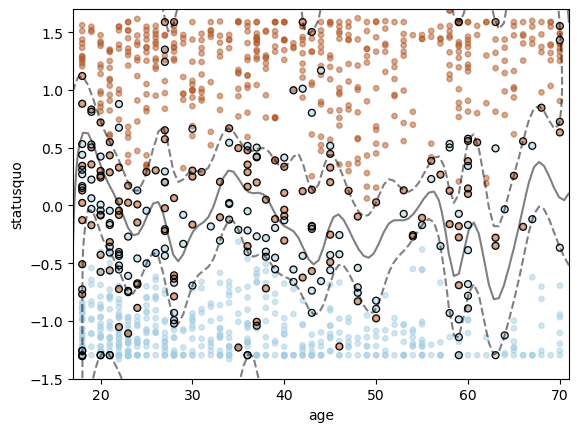

In [12]:
# Decision Function with Support Vectors
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap=plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

ax.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s = 25,
    linewidth = 0.9,
    facecolors = "none",
    edgecolors = "k",
    alpha = 1
)

plt.ylim(-1.5, 1.7)
plt.show()

## Support Vector Machines

- Now let us do some multiclass classification: Note that the survey answer was: Yes, No, Unsure, and Abstein.

- Can we predict these classes using SVMs? Yes! Let us see how it does?!

In [13]:
## Loading Chile data
chile_clean2 = chile.dropna()
chile_clean2['logincome'] = np.log(chile_clean2['income'])
chile_clean2['logpop'] = np.log(chile_clean2['population'])
dummies = pd.get_dummies(chile_clean2['sex'], prefix = 'sex', drop_first = True)
chile_clean2 = pd.concat([chile_clean2, dummies], axis=1)
dummies = pd.get_dummies(chile_clean2['region'], prefix = 'region', drop_first = True)
chile_clean2 = pd.concat([chile_clean2, dummies], axis=1)
dummies = pd.get_dummies(chile_clean2['education'], prefix = 'education', drop_first = True)
chile_clean2 = pd.concat([chile_clean2, dummies], axis=1)
print(chile_clean2.vote.value_counts())
## Loading Chile data
y = chile_clean2['vote']
X = chile_clean2[['age', 'statusquo', 'logincome', 'logpop', 'sex_M', 
                  'region_M', 'region_N', 'region_S', 'region_SA', 'education_PS', 'education_S']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 12345)
chile_clean2.head()

N    867
Y    836
U    551
A    177
Name: vote, dtype: int64


/var/folders/57/5cl1vf6549d34n3t9xpfz0fr0000gn/T/ipykernel_4439/2089051620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chile_clean2['logincome'] = np.log(chile_clean2['income'])
/var/folders/57/5cl1vf6549d34n3t9xpfz0fr0000gn/T/ipykernel_4439/2089051620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chile_clean2['logpop'] = np.log(chile_clean2['population'])


,region,population,sex,age,education,income,statusquo,vote,logincome,logpop,sex_M,region_M,region_N,region_S,region_SA,education_PS,education_S
0,N,175000,M,65.0,P,35000.0,1.00820,Y,10.463103,12.072541,1,0,1,0,0,0,0
1,N,175000,M,29.0,PS,7500.0,-1.29617,N,8.922658,12.072541,1,0,1,0,0,1,0
2,N,175000,F,38.0,P,15000.0,1.23072,Y,9.615805,12.072541,0,0,1,0,0,0,0
3,N,175000,F,49.0,P,35000.0,-1.03163,N,10.463103,12.072541,0,0,1,0,0,0,0
4,N,175000,F,23.0,S,35000.0,-1.10496,N,10.463103,12.072541,0,0,1,0,0,0,1


In [14]:
## Linear SVM (Support Vector Classifier)
svc = SVC(kernel = 'rbf', gamma = 1).fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  1  21   8  23]
 [  1 202  20  37]
 [  3  59  23  81]
 [  1  21  27 202]]
              precision    recall  f1-score   support

           A       0.17      0.02      0.03        53
           N       0.67      0.78      0.72       260
           U       0.29      0.14      0.19       166
           Y       0.59      0.80      0.68       251

    accuracy                           0.59       730
   macro avg       0.43      0.43      0.41       730
weighted avg       0.52      0.59      0.53       730



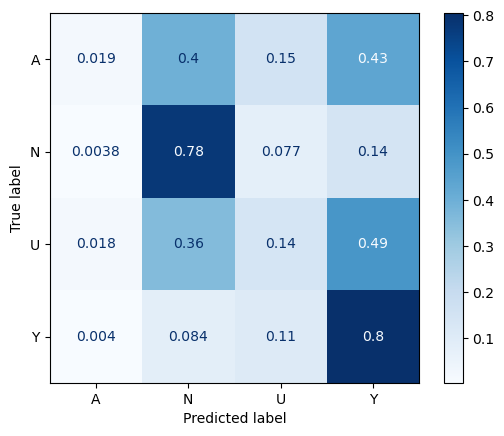

In [15]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

## Support Vector Machines

- This is pretty much it.

- There is something called [Support Vector Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), if you want to see the extension to this method to regression.

- Suggestion: Try this technique with the civil conflict dataset. And don't forget to rescale the variables.

# Deep Learning

## Deep Learning

- The next method we are going to cover is deep learning. 

- Deep learning is now at the frontier of Machine Learning knowledge.

- It is one of the most inventive flexible models there is.

- It does a fantastic job of predicting hard-to-see patterns in the data.

## Deep Learning

- We will see two deep learning methods: *Convoluted Neural Networks*, and *Recurrent Neural Networks*.
    + **Convoluted Neural Networks**: Does well with image recognition problems and other problems without recurrent data structures.
    + **Recurrent Neural Networks**: Does well with recurrent structures, such as time-series data (where present values depend on past values, such as GDP, stocks, and others).
    
- The best news computationally is that Google created a library called `TensorFlow`, which does all the estimations for us.

- We will learn how to use an interface to this library called `keras`.

## Deep Learning

- Let us see a very simple *feed-forward* neural network.

![nn1](../img/nn1.png)

## Deep Learning

- This neural network is, mathematically:

$$ f(X) \ = \ \beta_0 + \sum_k \beta_k h_k(X) $$

- The features we start our NN call the *input layer*.

- The output of our NN is called the *output layer*.

- And the insides we call the *hidden layers*.

## Deep Learning 

- In the case of a single feed-forward structure, we have one hidden layer:

![nn1](../img/nn1.png)

## Deep Learning 

- Each hidden layer is comprised by activation functions:

$$ A_k \ = \ h_k(X) \ = \ g(w_{k0} + \sum_j g(w_{kj}X_j) $$

- The activation function is based on the weights $w_{kj}$, estimated from the data

- And the $g(.)$ is a non-linear function specified by us.

## Deep Learning

- The main thing here is the shape of the $g()$ function.

- If $g$ is the identity function, we would recover a simple linear regression model.
    + The $g$ should be non-linear!

## Deep Learning

- If you look closely, the name neural networks would then make sense:
    + It seems like a bunch of neurons firing up depending on the activation.
    
- But there is something else going on here:
    + If you look at the activation functions carefully, you will realize they have new features!
    + So, the strength of Deep Learning is that it comes up with new features based on older features.

## Deep Learning

Choices for $g$: 

- *Sigmoid* activation function: 

$$ g(z) \ = \ \dfrac{1}{1 + e^{-z}}$$

- *Rectified linear unit* function:

$$ g(z) \ = \ (z)_+ $$

## Deep Learning

Example of these $g$s here:

![nn2](../img/nn2.png)

## Deep Learning

- And the reason why it is so good is that you can fit pretty much all functional forms:
    + Example: Can we fit a interaction term ($f(x_1, x_2) = x_1 \cdot x_2$)? Yes!

## Deep Learning

- Let: $X = (X_1. X_2)$, $K = 2$, $g(z) = z^2$. Assume we fit a feed-forward with two hidden layers (hence $K = 2$!) and find:

$$ \beta_0 = 0, \quad \beta_1 = \frac{1}{4}, \quad \beta_2 = -\frac{1}{4} $$

$$ w_{10} = 0, \quad w_{11} = 1, \quad w_{12} = 1 $$

$$ w_{20} = 0, \quad w_{21} = 1, \quad w_{22} = -1 $$

## Deep Learning

The activation functions are:

$$ h_1(X) \ = \ (0 + X_1 + X_2)^2 \ = \ (X_1 + X_2)^2$$

$$ h_2(X) \ = \ (0 + X_1 - X_2)^2 \ = \ (X_1 - X_2)^2$$


## Deep Learning

And the $f$ is:

$$ f(X) \ = \ 0 + \frac{1}{4}h_1(X) - \frac{1}{4}h_2(X) $$

And after some algebra:

$$ f(X)  \ = \ X_1 X_2 $$

- This is awesome! 
    + We started with a straightforward, functional form and reached a complex interaction term structure.
    + And this is the beauty of Deep Learning: it can easily capture the patterns from various functional forms.
    


## Deep Learning

- But most of the time, at the expense of a clear view of what is going on: *low interpretability*

Example: hand-writing classification problem discussed in the book.

![nn3](../img/nn3.png)

## Deep Learning

- In the next class, we will fit a few neural networks and study more complicated problems.

# Questions?

# See you next class
